# STU22004 Applied Probablity Group Project
----
| Team members| Student ID|
|-------------|---------|
|Leon Andorfi|23335878|
|Joel Matthew Jojan|23376190|
|Aryan Kapoor|22300775|
|Zicheng Liang|23331250|

In [1]:
import pandas as pd
import numpy as np
import matplot as mp
import seaborn as sns
import random
import json
from collections import defaultdict
from collections import Counter
# 60 sec * 90 min = 5400 secs 
# 5400 / 30 (30s per tick)
simulation_tick = 180 
teams = []

import matplotlib.pyplot as plt

## Question 1: Temperature Modeling
We will first plot the distribution estimate for $P$ when $∆t = 0.01$. We will pick the number of simulations to be 1000. Since the temperature change from some time $t$ to $t + ∆t$ is normally distributed, within each simulation we will sample $1/∆t$ values from a normal distribution with 0 mean and $\sqrt∆t$ standard deviation. Then, starting from time 0 and temperature 0, we will add the temperature changes one by one, and for each change record whether the current temperature is positive or not.

In [2]:
# Parameters we can choose

deltaT = 0.01
num_simulations = 1000

Formally, for $n=\frac{1}{\Delta t}$ samples $\left\{ s_1, s_2, \dots, s_n \right\}$, we define the proportion of positive temperatures $p$ as
$p=\frac{1}{n}\sum_{k=1}^{n}\textbf{1}_\mathbb{R^+}\left( \sum_{i=1}^{k} s_i \right)$, where $\textbf{1}_{\mathbb{R^+}}$ is the indicator function of the set of positive reals, defined as
$$
\textbf{1}_{\mathbb{R^+}}(x) =
\begin{cases}
1 & \text{if } x \in R^+, \\
0 & \text{if } x \notin R^+.
\end{cases}
$$

In [3]:
def get_positive_proportion(arr):
    num = cur = 0
    for t in arr:
        cur += t
        num += int(cur > 0)
    return num / arr.shape[0]

def get_P(deltaT, num_simulations=1000):
    num_temp_changes = int(1 / deltaT)
    temp_changes = np.random.normal(0, np.sqrt(deltaT), (num_simulations, num_temp_changes))
    return np.array(list(map(get_positive_proportion, temp_changes)))

Finally, we plot the computed values of $\left\{ p_1, p_2, \dots, p_m \right\}$ where $m$ is the number of simulations performed ($m=1000$ in our case).

Text(0, 0.5, 'Frequency')

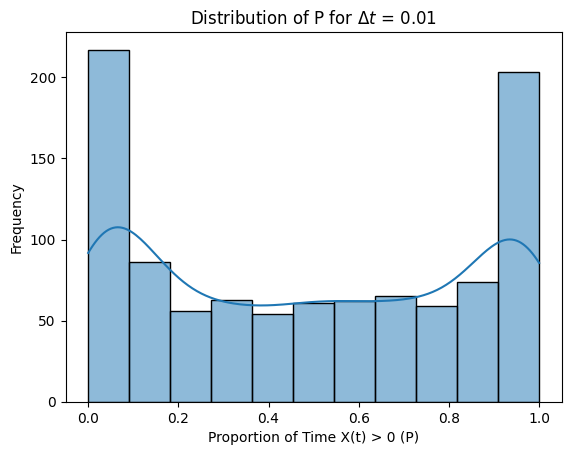

In [4]:
proportions = get_P(deltaT, num_simulations)
sns.histplot(proportions, kde=True)
plt.title(f'Distribution of P for $\\Delta t$ = {deltaT}')
plt.xlabel('Proportion of Time X(t) > 0 (P)')
plt.ylabel('Frequency')

Next step is to plot the distribution estimates for $\Delta t = 0.01, 0.001, 0.0001, 0.00001$.

In [5]:
deltaTs = [0.01, 0.001, 0.0001, 0.00001]
P_values = [get_P(delta_t) for delta_t in deltaTs]

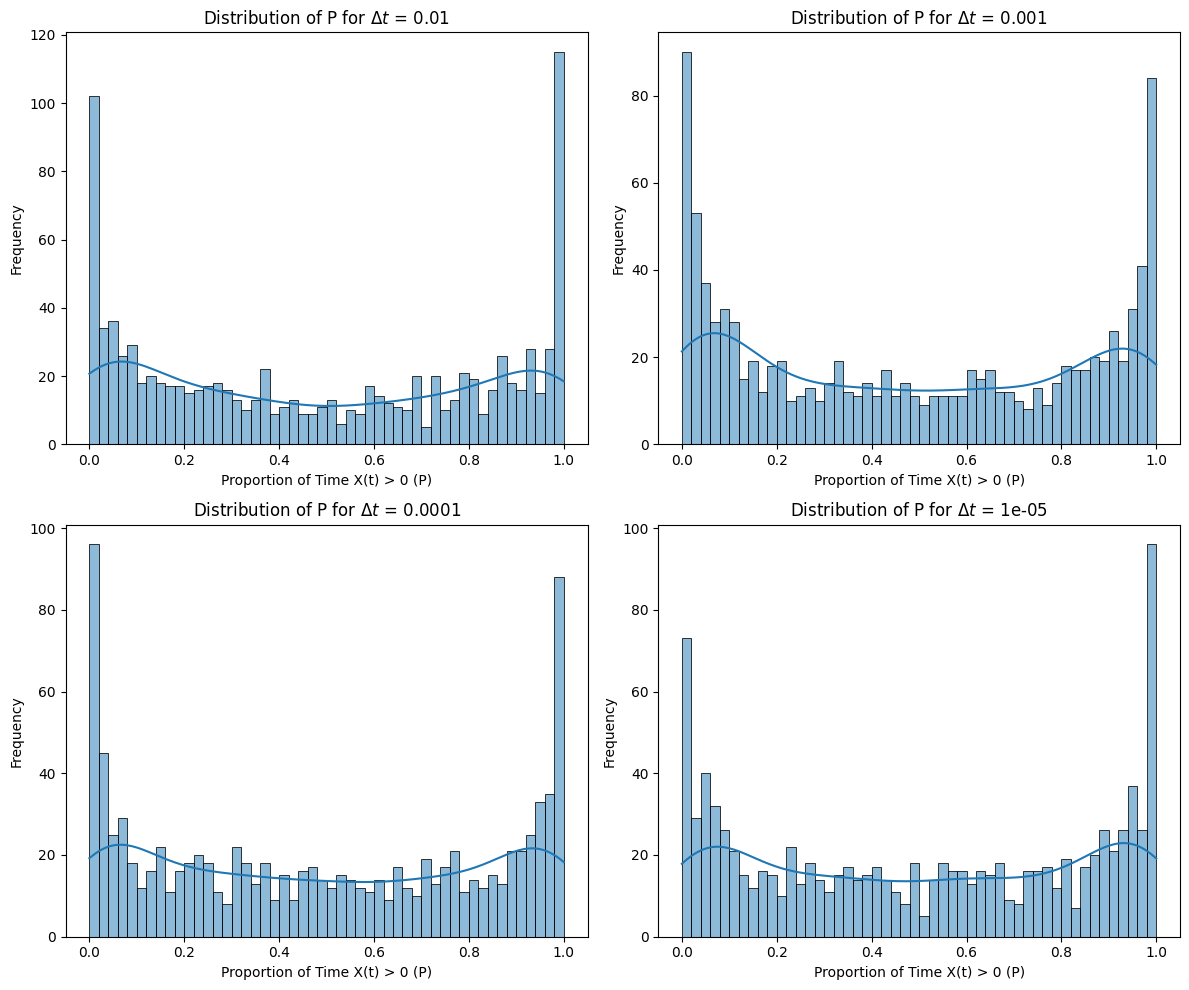

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, P_value in enumerate(P_values):
    sns.histplot(P_value, kde=True, bins=50, ax=axes[idx])
    axes[idx].set_title(f'Distribution of P for $\\Delta t$ = {deltaTs[idx]}')
    axes[idx].set_xlabel('Proportion of Time X(t) > 0 (P)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The following table contains mean and variance estimates for values of $\Delta t$.

In [7]:
means = [p.mean() for p in P_values]
vars = [p.var() for p in P_values]
dist_df = pd.DataFrame(list(zip(deltaTs, means, vars)), columns=['Δt', 'Mean', 'Variance'])
dist_df

,Δt,Mean,Variance
0,0.01000,0.483120,0.130526
1,0.00100,0.479092,0.129144
2,0.00010,0.491241,0.123418
3,0.00001,0.506252,0.122149


Now we turn to estimating the distribution of $T_{max}$. Similarly to $P$, The time at which the temperature is at its maximum can be defined as $t_{max}=\frac{1}{n}\underset{k \in S}{\arg\max} \left( \sum_{i=1}^{k} s_i \right)$ where $n=\frac{1}{\Delta t}$, $\left\{ s_1, s_2, \dots, s_n \right\}$ are the temperature change samples and $S=\left\{ x \in \mathbb{N} \mid x \le n \right\}$.

In [8]:
def get_max(arr):
    max_val = max_ind = cur = 0
    for i in range(arr.shape[0]):
        cur += arr[i]
        max_val = max(max_val, cur)
        max_ind = i if max_val == cur else max_ind

    return max_ind / arr.shape[0]

def get_Tmax(deltaT, num_simulations=1000):
    num_temp_changes = int(1 / deltaT)
    temp_changes = np.random.normal(0, np.sqrt(deltaT), (num_simulations, num_temp_changes))
    return np.array(list(map(get_max, temp_changes)))

In [9]:
Tmax_values = [get_Tmax(delta_t) for delta_t in deltaTs]

The following are the distribution estimates for $T_{max}$ when $\Delta t = 0.01, 0.001, 0.0001, 0.00001$.

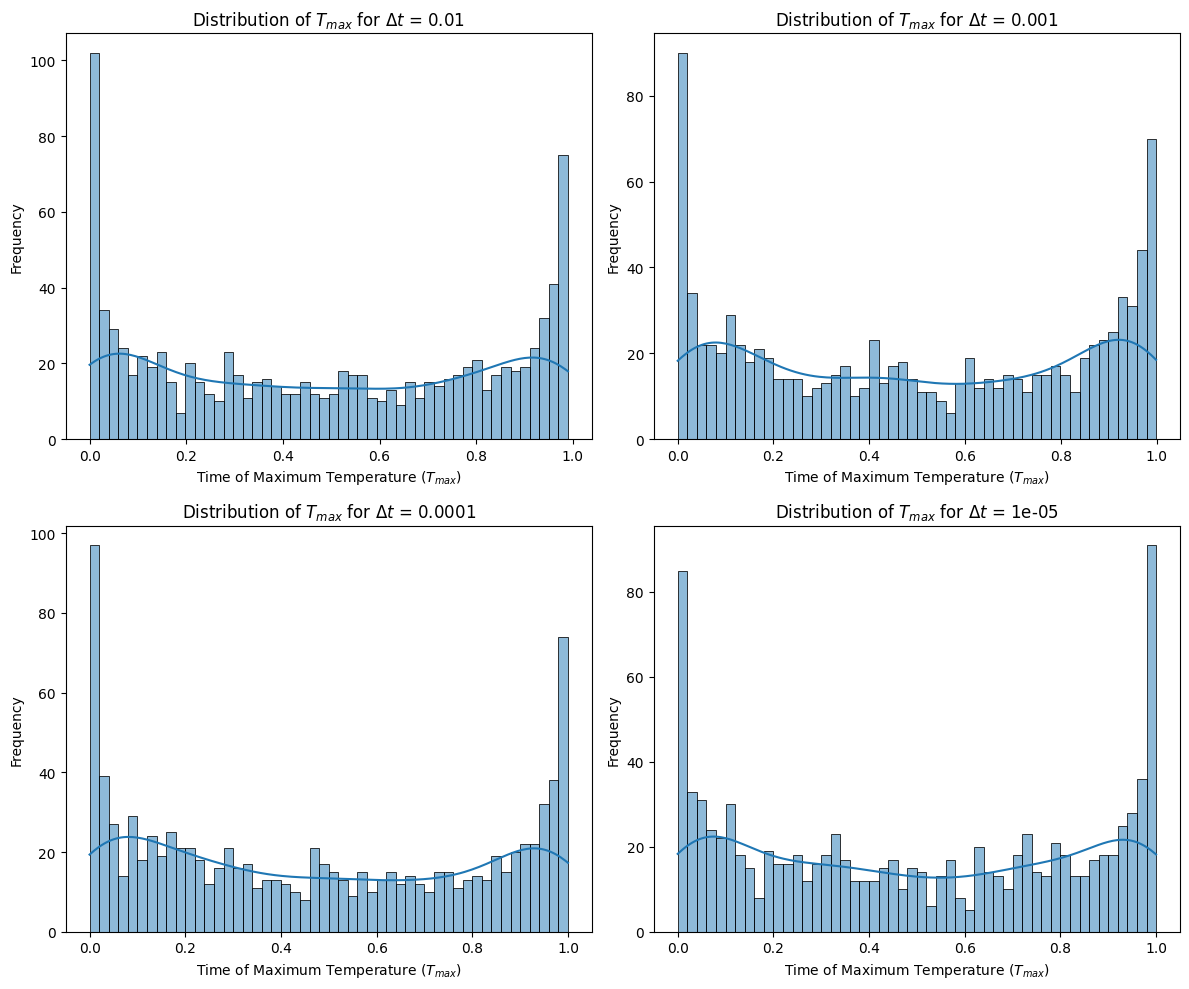

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, Tmax_value in enumerate(Tmax_values):
    sns.histplot(Tmax_value, kde=True, bins=50, ax=axes[idx])
    axes[idx].set_title(f'Distribution of $T_{{max}}$ for $\\Delta t$ = {deltaTs[idx]}')
    axes[idx].set_xlabel('Time of Maximum Temperature ($T_{max}$)')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The following table contains mean and variance estimates for value of $\Delta t$.

In [11]:
means = [t.mean() for t in Tmax_values]
vars = [t.var() for t in Tmax_values]
dist_df = pd.DataFrame(list(zip(deltaTs, means, vars)), columns=['Δt', 'Mean', 'Variance'])
dist_df

,Δt,Mean,Variance
0,0.01000,0.486120,0.122680
1,0.00100,0.498718,0.122597
2,0.00010,0.475438,0.121980
3,0.00001,0.495919,0.121837


### Analysis of Results

Distribution estimates of $P$ and $T_{max}$ seem to suggest that both random variables have identical distributions, with $\mu \approx 0.5$ and $\sigma^2 \approx 0.125$. A notable characteristic of both distributions are the heavy tails at 0 and 1. Simulating how the temperature changes over time for a few samples, we notice that some paths keep hovering over 0, shifting from positive to negative and negative to positive values. However, a good portion of paths start with a wave of positive/negative changes, and thus never go down/up to 0. These samples will have either $t_{max}=p=0$ (negative values at start) or $t_{max}=p=1.0$ (positive values at start).

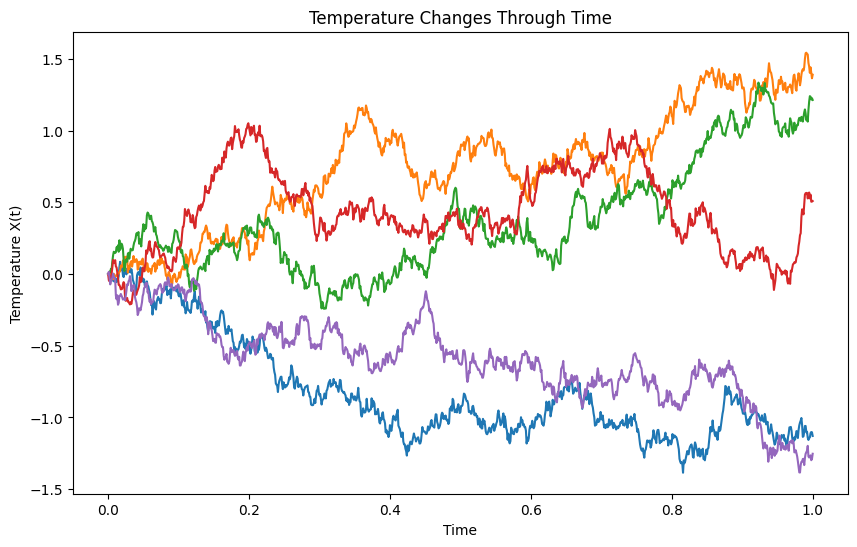

In [12]:
def simulate_change(delta_t):
    N_steps = int(1 / delta_t)
    dX = np.random.normal(0, np.sqrt(delta_t), size=N_steps)
    X = np.concatenate(([0], np.cumsum(dX)))
    time_grid = np.linspace(0, 1, N_steps + 1)
    return time_grid, X

delta_t = 0.001
num_paths = 5
plt.figure(figsize=(10, 6))

for _ in range(num_paths):
    t, X = simulate_change(delta_t)
    plt.plot(t, X)

plt.title('Temperature Changes Through Time')
plt.xlabel('Time')
plt.ylabel('Temperature X(t)')
plt.show()


-----
## Premier League Forecasting – Model Description
Our predictive model for Premier League matches uses a simulation-based approach, supported by player statistics extracted using the datascraper.py script. The script gathers comprehensive data from FBref and outputs a players.json file, which stores individual player attributes (avg. goals per game, shots per game, etc.).

### Simulation Framework
The simulation operates on a time-based system. Matches are simulated incrementally in discrete time "ticks." Each tick represents a specific period within the game where players make decisions and interact with the ball. The process begins with a random home-team player (excluding the goalkeeper) taking the kick-off and passing to a teammate.

At each tick, the player in possession of the ball has the following possible outcomes (events):

**Pass the Ball**: The player attempts to pass the ball, influenced by their passing accuracy and team tactics.\
**Shoot**: The player attempts a shot, with a scoring probability calculated based on historical data, their position, and individual scoring ability.\
**Lose Possession**: The player loses the ball, either due to interception, tackle, or misplay, transitioning control to the opposing team.\
**Retain Possession**: If none of the above occurs, the player holds the ball until the next tick.\

The likelihood of each event is dynamically computed using these collected data:

**Passing Probabilities**: Depend on player attributes (e.g., passing accuracy) and their role (e.g., midfielders are more likely to pass forward compared to defenders).\
**Shooting Probabilities**: Reflect player attributes and contextual factors such as distance to goal and defensive pressure.\
**Lose Possession Probabilities**: Influenced by player stats and opposing team's defensive strength.\

### Monte Carlo Simulations
For each match, we simulate thousands of iterations, each representing a potential outcome. Key outcomes (home win, away win, or draw) are determined based on goal differentials across these simulations. After a simulated game is finished, the number of goals scored/conceded by both teams and the match outcome (win/loss/draw) are recorded.

### Season Simulation
To forecast final league standings:

__Match Simulation__: Each match in the season is simulated multiple times.\
__Aggregate Results__: The average number of wins, draws, and losses for each team is calculated.\
__Final Points__: Points are assigned (3 for a win, 1 for a draw, 0 for a loss) to determine the final standings.\
__Goal Statistics__: Average goals scored and conceded are used as secondary metrics for ranking.\

More details will be given in the corresponding section

In [13]:
#Creates an array of the team names!
with open("./teamFormations.json", 'r') as teamFile:
        teamsJSON = json.load(teamFile)
for team in teamsJSON:
    teams.append(team['name'])

In [14]:
class player:
    '''Player Class'''
    
    def __init__(self, name, url, pos, team, isGoalkeeper, mp, starts, gamesPlayedForCurrentTeam, startsForCurrentTeam, 
                 savePercentage, tacklesPG, interceptionsPG, shotsPG, passesPG, progPassesRecievedPG, progCarriesPG ):
        self.name = name
        self.url = url
        self.position = pos
        self.team = team
        self.isGoalkeeper = isGoalkeeper

        #Common stats:
        self.matchesPlayed = mp
        self.starts = starts
        self.gamesPlayedForCurrentTeam = gamesPlayedForCurrentTeam
        self.startsForCurrentTeam = startsForCurrentTeam

        # GK STATS:
        self.savePercentage = savePercentage

        # Outfielder Stats:
        self.tacklesPG = tacklesPG
        self.interceptionsPG = interceptionsPG
        self.shotsPG = shotsPG
        self.passesPG = passesPG
        self.progPassesRecievedPG = progPassesRecievedPG
        self.progCarriesPG = progCarriesPG
    
    def __str__(self):
        return f"[Name: {self.name}"

##### Lineup Generation
The simulation iterates $N$ iterations times. This code is designed to use a Monte Carlo method to generate the most likely lineup to be chosen by the team for a game. We use weights based off of the players games played for the current team and their starts for the current team. We then store this in a 4 part dictionary containing the selected defenders, midfielders, forwards and goalkeeper. The size of each subsection is determined based on the teams lineups which are stored in the lineups.json file.

In [15]:
import os
def optimized_lineup_selection(defenders, midfielders, forwards, goalkeepers, lineup, iterations):
    """
    Optimized method for selecting starting lineup using Monte Carlo simulation.
    
    Key Optimizations:
    - Precompute weights once
    - Use more efficient data structures
    - Minimize repeated computations
    """
    # Precompute weight calculation to avoid repeated computations
    def calculate_weights(players):
        return [
            max(0.001, player['gamesPlayedForCurrentTeam'] / player['startsForCurrentTeam']) 
            if player['startsForCurrentTeam'] > 0 else 0.001 
            for player in players
        ]
    
    # Precompute weights for each position
    defender_weights = calculate_weights(defenders)
    midfielder_weights = calculate_weights(midfielders)
    forward_weights = calculate_weights(forwards)
    goalkeeper_weights = calculate_weights(goalkeepers)
    
    # Initialize selection count tracking
    defender_selection_counts = defaultdict(int)
    midfielder_selection_counts = defaultdict(int)
    forward_selection_counts = defaultdict(int)
    goalkeeper_selection_counts = defaultdict(int)
    
    # Efficient Monte Carlo simulation
    for _ in range(iterations):
        # Use efficient tracking instead of multiple set operations
        used_names = set()
        
        # Optimize player selection with precomputed weights
        def select_players(players, weights, position_count, selection_counts):
            # Filter out already used players
            available_players = [
                (player, weight) for player, weight in zip(players, weights) 
                if player['name'] not in used_names
            ]
            
            # Unzip players and weights
            available_player_list = [p[0] for p in available_players]
            available_weight_list = [p[1] for p in available_players]
            
            # Select players
            selected = random.choices(
                available_player_list, 
                weights=available_weight_list, 
                k=min(len(available_player_list), position_count)
            )
            
            # Update used names and selection counts
            for player in selected:
                used_names.add(player['name'])
                selection_counts[player['name']] += 1
            
            return selected
        
        # Select players for each position
        selected_defenders = select_players(
            defenders, defender_weights, lineup[0], defender_selection_counts
        )
        
        selected_midfielders = select_players(
            midfielders, midfielder_weights, lineup[1], midfielder_selection_counts
        )
        
        selected_forwards = select_players(
            forwards, forward_weights, lineup[2], forward_selection_counts
        )
        
        # Select goalkeeper (always one)
        available_goalkeepers = [
            (gk, weight) for gk, weight in zip(goalkeepers, goalkeeper_weights) 
            if gk['name'] not in used_names
        ]
        
        if available_goalkeepers:
            goalkeeper = random.choices(
                [gk[0] for gk in available_goalkeepers], 
                weights=[gk[1] for gk in available_goalkeepers], 
                k=1
            )[0]
            
            goalkeeper_selection_counts[goalkeeper['name']] += 1
    
    # Return selection counts for each position
    return {
        'defenders': defender_selection_counts,
        'midfielders': midfielder_selection_counts,
        'forwards': forward_selection_counts,
        'goalkeepers': goalkeeper_selection_counts
    }

def predict_starting_lineup(team_name, iterations=100, base_dir="./team_files"):
    """
    Predict the starting lineup for a team using a Monte Carlo simulation.

    Parameters:
        team_name (str): The name of the team to predict the lineup for.
        iterations (int): Number of Monte Carlo iterations.
        base_dir (str): Directory containing team-specific JSON files.

    Returns:
        list: Predicted starting lineup as an array of player objects.
    """
    # Create a safe filename version of the team name
    safe_team_name = ''.join(char for char in team_name if char.isalnum() or char.isspace()).rstrip()
    safe_team_name = safe_team_name.replace(' ', '_')
    
    # Construct the file path for the team's JSON file
    file_path = os.path.join(base_dir, f"{safe_team_name}.json")
    
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No JSON file found for team {team_name}. Searched at: {file_path}")

    # Read team formations (assuming this file is still in the original location)
    with open("./teamFormations.json", 'r') as formationFile:
        formations = json.load(formationFile)

    # Default formation
    lineup = "4,3,3"
    for formation in formations:
        if formation["name"] == team_name:
            lineup = formation["formation"]

    # Load player data from team-specific file
    with open(file_path, 'r') as file:
        players = json.load(file)

    lineup = list(map(int, lineup.split(",")))

    # Separate players by position
    team_players = [p for p in players]
    defenders = [p for p in players if 'DF' in p['position'].split(', ')]
    midfielders = [p for p in players if 'MF' in p['position'].split(', ')]
    forwards = [p for p in players if 'FW' in p['position'].split(', ')]
    goalkeepers = [p for p in players if 'GK' in p['position'].split(', ')]

    if not goalkeepers:
        raise ValueError(f"No goalkeepers found for team {team_name}")

    # Use the optimized selection method
    selection_results = optimized_lineup_selection(
        defenders, midfielders, forwards, goalkeepers, lineup, iterations
    )

    # Determine the most likely starting lineup
    predicted_defenders = sorted(
        selection_results['defenders'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[0]]

    predicted_midfielders = sorted(
        selection_results['midfielders'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[1]]

    predicted_forwards = sorted(
        selection_results['forwards'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:lineup[2]]

    predicted_goalkeeper = max(
        selection_results['goalkeepers'].items(), 
        key=lambda x: x[1]
    )

    # Aggregate all player objects into a single list
    starting_lineup = []
    selected_players = set()

    # Add goalkeeper
    starting_lineup.append(next(player for player in goalkeepers if player['name'] == predicted_goalkeeper[0]))
    selected_players.add(predicted_goalkeeper[0])

    # Add defenders
    for defender in predicted_defenders:
        player = next(player for player in defenders if player['name'] == defender[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add midfielders
    for midfielder in predicted_midfielders:
        player = next(player for player in midfielders if player['name'] == midfielder[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Add forwards
    for forward in predicted_forwards:
        player = next(player for player in forwards if player['name'] == forward[0])
        starting_lineup.append(player)
        selected_players.add(player['name'])

    # Fill remaining gaps for each position
    while len(starting_lineup) < 11:
        remaining_pool = [p for p in team_players if p['name'] not in selected_players]
        if not remaining_pool:
            break
        player = remaining_pool.pop(0)
        if len(starting_lineup) < lineup[0] + 1:  # Defenders gap
            starting_lineup.append(player)
        elif len(starting_lineup) < lineup[0] + lineup[1] + 1:  # Midfielders gap
            starting_lineup.append(player)
        else:  # Forwards gap
            starting_lineup.append(player)
        selected_players.add(player['name'])
        

    return starting_lineup

#### Initialize Match
The function `initialize_match` sets up the initial state of the match by generating team lineups, determining possession, and preparing the game state

In [16]:

def initialize_match(home_team, away_team):
    """
    Initializes the match by generating lineups and setting initial game state.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.

    Returns:
        dict: Game state including possession, teams, and stats.
    """

    # Generate lineups 
    home_lineup = predict_starting_lineup(home_team)
    away_lineup = predict_starting_lineup(away_team)
    
    # Filter midfielders (MF) from the home lineup
    midfielders = [player for player in home_lineup if 'MF' in player['position'].split(', ')]

    # Choose a random midfielder to start possession
    if midfielders:
        initial_possession_player = random.choice(midfielders)
    else:
        # Fallback if no midfielders are available
        initial_possession_player = random.choice(home_lineup)


    game_state = {
        "possession_team": "home",  # Ball starts with the home team
        "possession_player": initial_possession_player,  # Random home player
        "home_team": home_lineup,
        "away_team": away_lineup,
        "home_score": 0,
        "away_score": 0,
        "events": []  # Log of game events
    }
    return game_state

#### Player Action

Our code breaks down the actions a player can perform within each tick down into 4 parts. By abstracting this as such it helps us simplify the simulation while also creating a somewhat realistic method of predicting games. 
At every tick, the possession player is able to either pass, shoot, keep or lose the ball.
$$P(Pass) = \frac{\text{passesPG}}{\text{simulationTick}}$$ 
$$P(Shot) = shotsPG$$
$$P(Lose) = \frac{\text{defensivePressure}}{\text{simulationTick}}$$
$$P(Keep) = 1 - \text{P(Pass) + P(Shot) + P(Lose)} $$
We then use a distribution based on these probabilities to return the action performed by the player.


In [17]:
def player_action(player, possession_team, game_state, tick):
    """
    Determines the player's action for the current tick.

    Parameters:
        player (dict): Player with possession.
        possession_team (str): 'home' or 'away'.
        game_state (dict): Current game state.
        tick (int): Current tick of the simulation (e.g., 1 minute).

    Returns:
        str: Action performed ('pass', 'shoot', 'keep', 'lose').
    """

    # Get the opposing team
    opp_team = game_state["away_team"] if possession_team == "home" else game_state["home_team"]

    defensive_pressure = sum(p.get("tacklesPG", 0) + p.get("interceptionsPG", 0) for p in opp_team)
    lose_prob = defensive_pressure / simulation_tick if simulation_tick > 0 else 0.2  # Avoid division by zero

    # Calculate probabilities for other actions
    shots_pg = player.get("shotsPG", 0.1)
    passes_pg = player.get("passesPG", 10) / simulation_tick
    # print(f"shots : {shots_pg}, passes : {passes_pg}")
    keep_prob = 1 - (shots_pg + passes_pg + lose_prob)

    # print(f"{keep_prob + shots_pg + passes_pg + lose_prob}")
    # Ensure probabilities are valid
    if keep_prob < 0:
        keep_prob = 0

    # Weighted random choice for the action
    
    action = random.choices(
        ["pass", "shoot", "keep", "lose"],
        weights=[passes_pg, shots_pg, keep_prob, lose_prob],
        k=1
    )[0]
    return action


##### Pass ball:
To select a teammate for passing, the **current possession player excludes themselves and any goalkeepers.**
The selection probability for each teammate is assigned using the players *progressivePassesRecieved* statistic as well as the *position relativity multiplier* which is assigned based on the where the players positioned. 
*In effect, defenders -> midfielders is likely, midfielders -> forwards also likely, forwards -> defenders is unlikely.*
This weight is then normalized and we assign it to the player for our selection process.

In [18]:
def pass_ball(player, possession_team, game_state):
    """
    Handle Passing the ball to a teammate

    Parameters:
        player     (dict) : CurrentPlayer
        team       (list) : team the player belongs to
        game_state (dict) : Current game state

    Returns:
        (dict) : updated game state
    """

    # Choose a random teammate to pass to (excluding the current player)
    teammates = [p for p in possession_team if p["name"] != player["name"] and not p['isGoalkeeper']]
    if not teammates:
        return game_state  # No teammates available, keep possession
    
    weights = []

    for teammate in teammates:
        #Base weight is progressive passes recieved if available.
        prog_pass_weight = teammate.get("progPassesRecievedPG", 1) # Defaults to 1 if not available

        #Positional Relative weight
        positional_weight = 1.0
        if "DF" in player["position"] and "MF" in teammate["position"]:
            positional_weight = 1.5
        elif "MF" in player["position"] and "FW" in teammate["position"]:
            positional_weight = 1.5
        elif "DF" in player["position"] and "FW" in teammate["position"]:
            positional_weight = 1.0
        elif "FW" in player["position"] and "MF" in teammate["position"]:
            positional_weight = 1.2
        
        total_weight = prog_pass_weight * positional_weight
        weights.append(total_weight)
    
    # Normalize weights to sum to 1
    total_weight_sum = sum(weights)
    normalized_weights = [w / total_weight_sum for w in weights]

    # Choose a teammate based on weighted probabilities
    new_player = random.choices(teammates, weights=normalized_weights, k=1)[0]

    game_state["possession_player"] = new_player
    game_state["events"].append(f"{player['name']} passed to {new_player['name']}")

    return game_state

### Attempt Shoot

We have encountered a problem while implementing "Attempt Shoot" function: how should we simulate the chance of scoring? 

The ideal solution would be a linear regression $z = ax + by + c$, where $z$ is the scoring chance, $x$ is the opponent goal keeper's chance of saving, $y$ is the current player's chance of scoring. However, we needed many past games'records with scoreline, player lineup, shooting attemps, etc. which we were not able to find or scrap. 

With that being said, we turned to an alternative strategy: based on a simple formula $z = 1 - (x - y)$ where z is the scoring chance, x is the goal keeper's historical chance of saving, y is the player's historical chance of scoring; we introduced a multiplier k derived from premier league's team ranking from past year. The higher a team's past rank, the larger the k is. Our scoring chance formula finally becomes $z = k (1 - x - y)$.

In [19]:
teams_rankings = [
    "Manchester City",
    "Liverpool",
    "Tottenham",
    "Chelsea",
    "Arsenal",
    "Brighton",
    "Fulham",
    "Manchester Utd",
    "Newcastle Utd",
    "Nottingham Forest",
    "Bournemouth",
    "Brentford",
    "Everton",
    "Aston Villa",
    "Crystal Palace",
    "Leicester City",
    "Wolves",
    "West Ham",
    "Ipswich Town",
    "Southampton",
]

In [20]:
def attempt_shoot(player, oppGK, game_state, isHome, team_name):
    """
    Handles a shot attempt.

    Parameters:
        player     (dict): Player attempting the shot.
        oppGK      (dict): Opposition Goalkeeper
        game_state (dict): Current game state.
        isHome    (bool): Whether the player belongs to the home team.

    Returns:
        dict: Updated game state.
    """
    # scoring chance for the player
    k = 0.16 + 0.08 * (len(teams_rankings) - teams_rankings.index(team_name)) / len(teams_rankings)
    # Normalize and weight factors
    gk_save_factor = oppGK["savePercentage"] / 100.0
    shot_pg = player.get("shotsPG", 0.0)
    
    # More sophisticated scoring chance calculation
    scoring_chance = min(1.0, k * max(0.0, 
        1 - gk_save_factor + 
        shot_pg  # Adjust multiplier based on data characteristics
    ))
    
    
    # the final solution: run a linear regression for the scoring function
    dice = random.uniform(0.0, 1.0)
    
    if(dice < scoring_chance):
        if(isHome):
            game_state["home_score"] += 1
        else:
            game_state["away_score"] += 1
        game_state["events"].append(f"{player['name']} scored!")
    else:
        game_state["events"].append(f"{player['name']} missed the shot.")
    
    game_state["possession_team"] = "away" if isHome else "home"
    game_state["possession_player"] = random.choice(
        game_state["away_team"] if isHome else game_state["home_team"]
    )

    return game_state

#### Simulate tick

The simulate_tick function models a single tick of a soccer game simulation, determining the outcomes of player actions and updating the game state accordingly.   
It identifies the team in possession, the opposition team, the opposition goalkeeper and then uses these facts to run the action function. The action function returns the action performed by the possession player for that tick then we return the gameState for that tick.

In [21]:

def simulate_tick(game_state, tick):
    """
    Simulates a single tick of the game.

    Parameters:
        game_state (dict): Current game state.

    Returns:
        dict: Updated game state.
    """

    player = game_state["possession_player"]
    team = game_state["home_team"] if game_state["possession_team"] == "home" else game_state["away_team"]
    team_name = player['team']
    opp_team = game_state["home_team"] if game_state["possession_team"] == "away" else game_state["home_team"]
    oppGK = next((p for p in opp_team if p['isGoalkeeper']), None)

    action = player_action(player, game_state["possession_team"], game_state, tick)

    if action == "pass":
        game_state = pass_ball(player, team, game_state)

    elif action == "shoot":
        is_home = game_state["possession_team"] == "home"
        game_state = attempt_shoot(player, oppGK, game_state, is_home, team_name)

    elif action == "keep":
        game_state["events"].append(f"{player['name']} keeps the ball.")

    elif action == "lose":
        game_state["possession_team"] = "away" if game_state["possession_team"] == "home" else "home"
        game_state["possession_player"] = random.choice(
            game_state["away_team"] if game_state["possession_team"] == "away" else game_state["home_team"]
        )
        game_state["events"].append(f"{player['name']} lost the ball.")
        
        #print(f"updated game state {game_state}")

    return game_state

In [22]:
def simulate_match_with_logging(home_team, away_team):
    """
    Simulates a full match and returns game state with tick-by-tick logging.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.

    Returns:
        dict: Final game state with tick-by-tick events.
    """
    game_state = initialize_match(home_team, away_team)

    # Initialize tracking metrics
    match_data = {
        "ticks": [],
        "home_score": [],
        "away_score": [],
        # "home_passes": [],
        # "away_passes": [],
        "home_shots": [],
        "away_shots": [],
    }


    # home_passes, away_passes = 0, 0
    home_shots, away_shots = 0, 0
    for tick in range(1, simulation_tick+1):
        game_state = simulate_tick(game_state, tick)
        
        # Track events for plotting
        match_data["ticks"].append(tick)
        match_data["home_score"].append(game_state["home_score"])
        match_data["away_score"].append(game_state["away_score"])

        # Count passes and shots
        for event in game_state["events"]:
            #if "passed" in event:
            #    if "home" in game_state["possession_team"]:
            #        home_passes += 1
            #    else:
            #        away_passes += 1
            if "shot" in event or "scored" in event:
                if "home" in game_state["possession_team"]:
                    home_shots += 1
                else:
                    away_shots += 1

        #match_data["home_passes"].append(home_passes)
        #match_data["away_passes"].append(away_passes)
        match_data["home_shots"].append(home_shots)
        match_data["away_shots"].append(away_shots)

    return match_data

In [23]:
def monte_carlo_match_simulation(home_team, away_team, n_simulations=10000):
    """
    Runs Monte Carlo simulations for the match to estimate the most likely result.

    Parameters:
        home_team (list): Home team players.
        away_team (list): Away team players.
        n_simulations (int): Number of simulations to run.

    Returns:
        dict: Results including most common scoreline and average stats.
    """
    results = {
        "scorelines": Counter(),
        "home_goals": 0,
        "away_goals": 0,
        "home_score": 0,
        "away_score": 0,
        "home_vic": 0,
        "away_vic": 0,
        "draw": 0,
    }

    for _ in range(n_simulations):
        
        game_state = simulate_match_with_logging(home_team, away_team)
        
        # Ensure scores are integers
        home_score = int(game_state["home_score"][-1])
        away_score = int(game_state["away_score"][-1])
        final_score = (home_score, away_score)  # Tuple is immutable and hashable

        # Track the scoreline
        results["scorelines"][final_score] += 1

        # Aggregate total goals
        results["home_goals"] += home_score
        results["away_goals"] += away_score
        
        # Aggregate game results
        if (home_score > away_score): results["home_vic"] += 1
        elif (home_score < away_score): results["away_vic"] += 1
        elif (home_score == away_score): results["draw"] += 1
        
    results["home_score"] = 3 * results["home_vic"] + results["draw"]
    results["away_score"] = 3 * results["away_vic"] + results["draw"]

    # Calculate averages
    results["average_home_goals"] = results["home_goals"] / n_simulations
    results["average_away_goals"] = results["away_goals"] / n_simulations

    # Most common scoreline
    results["most_common_scoreline"] = results["scorelines"].most_common(1)[0]

    return results



In [24]:
import multiprocessing
from collections import Counter

# Ensure proper multiprocessing method for Jupyter and macOS
if __name__ == '__main__' or __name__ == '__main__.ipynb':
    # This guard is crucial for Jupyter Notebook multiprocessing
    multiprocessing.set_start_method('fork')  # Recommended for macOS

def run_single_simulation(args):
    """
    Worker function for match simulation in Jupyter environment.
    
    Critical Considerations for Jupyter Multiprocessing:
    1. Must be defined at module level
    2. Simple, picklable arguments
    3. Predictable, self-contained logic
    """
    home_team, away_team = args
    game_state = simulate_match_with_logging(home_team, away_team)
    
    home_goals = int(game_state["home_score"][-1])
    away_goals = int(game_state["away_score"][-1])
    
    if home_goals > away_goals:
        game_result = "home_vic"
    elif home_goals < away_goals:
        game_result = "away_vic"
    else:
        game_result = "draw"
    
    result = {
        "home_goals": home_goals,
        "away_goals": away_goals,
        "final_goals": (home_goals, away_goals),
        "game_result": game_result
    }
    
    return result

def monte_carlo_match_simulation_parallel(home_team, away_team, n_simulations):
    """
    Parallel Monte Carlo simulation optimized for Jupyter on macOS.
    
    Key Jupyter-Specific Multiprocessing Strategies:
    - Use 'fork' method for macOS compatibility
    - Explicit process count management
    - Robust error handling
    """
    # Prepare simulation arguments
    simulation_args = [(home_team, away_team) for _ in range(n_simulations)]
    
    # Determine optimal process count
    # Reduces overhead while maximizing parallel efficiency
    num_cores = max(1, multiprocessing.cpu_count() - 1)
    
    try:
        with multiprocessing.Pool(processes=num_cores) as pool:
            # Distribute simulations across available cores
            simulations = pool.map(run_single_simulation, simulation_args)
    except Exception as e:
        print(f"Multiprocessing error: {e}")
        # Fallback to sequential simulation if parallel fails
        simulations = [run_single_simulation(args) for args in simulation_args]
    
    # Results aggregation remains similar to previous implementation
    results = {
        "scorelines": Counter(),
        "home_goals": 0,
        "away_goals": 0,
        "home_score": 0,
        "away_score": 0,
        "home_vic": 0,
        "away_vic": 0,
        "draw": 0,
    }
    
    for result in simulations:
        final_goals = result["final_goals"]
        results["scorelines"][final_goals] += 1
        results["home_goals"] += result["home_goals"]
        results["away_goals"] += result["away_goals"]
        
        if result["game_result"] == "home_vic":
            results["home_vic"] += 1
        elif result["game_result"] == "away_vic":
            results["away_vic"] += 1
        else:
            results["draw"] += 1
    
    # Performance and statistical calculations
    results["home_score"] = 3 * results["home_vic"] + results["draw"]
    results["away_score"] = 3 * results["away_vic"] + results["draw"]
    results["average_home_goals"] = results["home_goals"] / n_simulations
    results["average_away_goals"] = results["away_goals"] / n_simulations
    
    results["most_common_scoreline"] = results["scorelines"].most_common(1)[0] if results["scorelines"] else None
    
    return results

In [25]:
import matplotlib.pyplot as plt

def plot_scoreline_distribution(scorelines):
    """
    Plots the distribution of the top x% of scorelines from Monte Carlo simulations.

    Parameters:
        scorelines (Counter): Frequency of scorelines from simulations.
        x_percent (float): The percentage of total data to display (0-100).
    """
    
    x_percent = 80
    
    # Sort scorelines by frequency in descending order
    sorted_scorelines = sorted(scorelines.items(), key=lambda item: item[1], reverse=True)
    
    # Calculate total frequency
    total_frequency = sum(scorelines.values())
    
    # Calculate the cumulative sum and filter top x% data
    cumulative_frequency = 0
    filtered_scorelines = []
    for scoreline, freq in sorted_scorelines:
        cumulative_frequency += freq
        filtered_scorelines.append((scoreline, freq))
        if cumulative_frequency / total_frequency * 100 >= x_percent:
            break
    
    # Unpack filtered scorelines
    filtered_scoreline_strings = [f"{home}-{away}" for home, away in dict(filtered_scorelines).keys()]
    filtered_frequencies = [freq for _, freq in filtered_scorelines]
    
    # Plot the filtered data
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_scoreline_strings, filtered_frequencies, color="skyblue")
    plt.title(f"Top {x_percent}% Scoreline Distribution (Monte Carlo Simulation)")
    plt.xlabel("Scoreline (Home-Away)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


----
#### Testing the accuracy of single game simulation
Running 10000 games on different home and away team settings to test the accuray of the model, the test set includes four tests:
1. Game between two strong teams (Manchester City vs. Chelsea)
2. Game between one strong team and one weaker team (Manchester City vs. Ispwich Town)
3. Game between the same two strong teams, but exchange home-away setting (Chelsea vs. Manchester City)

For each test, we compare an expected result from poisson distribution with the model's result.

---
##### Expected probability using poisson distribution

The probability of a specific scoreline $(G_{Home}, G_{Away})$ is 

$P(G_{Home} = k, G_{Away} = m) = P(G_{Home} = k) \cdot P(G_{Away} = m)$

where $P(G = x) = \frac{\lambda^{x}e^{-\lambda}}{x!}$

Currently, the team's lambda is obtained as a sum of the goals per game from each player in the lineup. We compare the simulation result with the poisson probability, then validate our model's accuracy with KL-divergence.

In [26]:
from scipy.stats import poisson

def calculate_team_lambda(team_name):
    team_lambda = 0
    team_lineup = predict_starting_lineup(team_name, 10000)
    for player in team_lineup:
        team_lambda += player.get("shotsPG", 0.0)
    return team_lambda

def calculate_outcome_probabilities(home_team, away_team, max_goals=10):
    lambda_home = calculate_team_lambda(home_team)
    lambda_away = calculate_team_lambda(away_team)
    home_win_prob = 0
    away_win_prob = 0
    draw_prob = 0
    
    for home_goals in range(max_goals+1):
        for away_goals in range(max_goals + 1):
            prob = poisson.pmf(home_goals, lambda_home) * poisson.pmf(away_goals, lambda_away)
            if home_goals > away_goals:
                home_win_prob += prob
            elif home_goals < away_goals:
                away_win_prob += prob
            else: 
                draw_prob += prob
                
    return home_win_prob, draw_prob, away_win_prob

In [27]:
def empirical_probabilities(simulation_results, n_simulations):
    total_matches = n_simulations
    home_wins = simulation_results["home_vic"]
    away_wins = simulation_results["away_vic"]
    draws = simulation_results["draw"]
    
    return home_wins / total_matches, draws / total_matches, away_wins / total_matches

In [28]:
import scipy.stats as stats
from typing import Dict, Any
def analyze_match_simulation(home_team: str, away_team: str, monte_carlo_results: Dict, n_simulations: int) -> Dict[str, Any]:
    """
    Comprehensive analysis of match simulation results with statistical comparisons.
    
    Args:
        home_team (str): Name of the home team
        away_team (str): Name of the away team
        monte_carlo_results (dict): Results from Monte Carlo simulations
        n_simulations (int): Number of simulations performed
    
    Returns:
        dict: Detailed analysis of simulation results
    """
    # Calculate Poisson and Empirical Probabilities
    home_win, draw, away_win = calculate_outcome_probabilities(home_team, away_team)
    empirical_home_win, empirical_draw, empirical_away_win = empirical_probabilities(monte_carlo_results, n_simulations)
    
    # Probability Differences
    prob_differences = {
        'Home Win': {
            'Poisson': home_win, 
            'Empirical': empirical_home_win, 
            'Difference': empirical_home_win - home_win
        },
        'Draw': {
            'Poisson': draw, 
            'Empirical': empirical_draw, 
            'Difference': empirical_draw - draw
        },
        'Away Win': {
            'Poisson': away_win, 
            'Empirical': empirical_away_win, 
            'Difference': empirical_away_win - away_win
        }
    }
    
    # Statistical Tests
    categories = ['Home Win', 'Draw', 'Away Win']
    poisson_probs = [home_win, draw, away_win]
    simulation_probs = [empirical_home_win, empirical_draw, empirical_away_win]
    
    # Prepare frequencies for chi-square test
    expected_frequencies = [p * n_simulations for p in poisson_probs]
    observed_frequencies = [p * n_simulations for p in simulation_probs]
    
    # Adjust for floating-point differences
    total_observed = sum(observed_frequencies)
    total_expected = sum(expected_frequencies)
    
    if total_observed != total_expected:
        scaling_factor = total_observed / total_expected
        expected_frequencies = [freq * scaling_factor for freq in expected_frequencies]
    
    # Chi-Square Test
    chi2_stat, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    
    # Kullback-Leibler Divergence
    kl_divergence = stats.entropy(simulation_probs, poisson_probs)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    x = np.arange(len(categories))
    width = 0.35
    
    plt.bar(x - width/2, poisson_probs, width, label='Poisson Model', alpha=0.7)
    plt.bar(x + width/2, simulation_probs, width, label='Simulation Results', alpha=0.7)
    
    plt.xlabel('Outcomes')
    plt.ylabel('Probability')
    plt.title(f'Probability Comparison: {home_team} vs {away_team}')
    plt.xticks(x, categories)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Comprehensive Results Dictionary
    results = {
        'Team Information': {
            'Home Team': home_team,
            'Away Team': away_team
        },
        'Simulation Summary': {
            'Total Simulations': n_simulations,
            'Home Victories': monte_carlo_results['home_vic'],
            'Away Victories': monte_carlo_results['away_vic'],
            'Draws': monte_carlo_results['draw']
        },
        'Scoreline Analysis': {
            'Most Common Scoreline': monte_carlo_results['most_common_scoreline'],
            'Average Home Goals': monte_carlo_results['average_home_goals'],
            'Average Away Goals': monte_carlo_results['average_away_goals']
        },
        'Probability Comparison': prob_differences,
        'Statistical Tests': {
            'Chi-Square Statistic': chi2_stat,
            'Chi-Square P-Value': p_value,
            'KL Divergence': kl_divergence
        }
    }
    
    return results

In [29]:
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from scipy.stats import entropy

def plot_poi_sim_differences_with_chi_square(home_team, away_team, monte_carlo_results, n_simulations):
    # Calculate probabilities
    home_win, draw, away_win = calculate_outcome_probabilities(home_team, away_team)  # Poisson probabilities
    empirical_home_win, empirical_draw, empirical_away_win = empirical_probabilities(monte_carlo_results, n_simulations)

    # Report the difference
    home_diff = empirical_home_win - home_win
    away_diff = empirical_away_win - away_win
    draw_diff = empirical_draw - draw
    
    print(f"The total difference is: {abs(home_diff) + abs(away_diff) + abs(draw_diff)}")
    print(f"Home difference is: {home_diff}")
    print(f"Draw difference is: {draw_diff}")
    print(f"Away difference is: {away_diff}")

    # Probabilities
    categories = ['Home Win', 'Draw', 'Away Win']
    poisson_probs = [home_win, draw, away_win]
    simulation_probs = [empirical_home_win, empirical_draw, empirical_away_win]

    # Perform chi-square test
    # Convert probabilities to frequencies for chi-square test
    expected_frequencies = [p * n_simulations for p in poisson_probs]
    observed_frequencies = [p * n_simulations for p in simulation_probs]

    # Adjust for floating-point differences
    total_observed = sum(observed_frequencies)
    total_expected = sum(expected_frequencies)
    
    if total_observed != total_expected:
        scaling_factor = total_observed / total_expected
        expected_frequencies = [freq * scaling_factor for freq in expected_frequencies]


    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    # Plot
    plt.bar(categories, poisson_probs, alpha=0.7, label='Poisson Model')
    plt.bar(categories, simulation_probs, alpha=0.7, label='Simulation Results')
    plt.ylabel('Probability')
    plt.title('Comparison of Poisson and Simulation Probabilities')
    plt.legend()
    plt.show()

    # Print chi-square test results
    print(f"Chi-square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:  # Significance level (alpha = 0.05)
        print("The observed and expected frequencies differ significantly.\n")
    else:
        print("No significant difference between observed and expected frequencies.\n")

    # Calculate KL divergence
    kl_divergence = entropy(simulation_probs, poisson_probs)
    print(f"KL Divergence: {kl_divergence:.5f}")

    # Interpret KL divergence
    if kl_divergence < 0.01:
        print("The distributions are very similar (low divergence).")
    elif kl_divergence < 0.1:
        print("The distributions have some differences, but are still reasonably close.")
    else:
        print("The distributions are significantly different.")


In [30]:
import numpy as np
import pandas as pd

def create_concise_summary(results: Dict[str, Any]) -> Dict[str, pd.DataFrame]:
    """
    Create a concise summary of match simulation results
    
    Args:
        results (dict): Comprehensive match simulation results
    
    Returns:
        dict: Dictionary of pandas DataFrames with key insights
    """
    # Total Simulations
    total_sims = results['Simulation Summary']['Total Simulations']
    
    # Victories and Outcome Probabilities
    outcomes_data = {
        'Outcome': ['Home Victory', 'Away Victory', 'Draw'],
        'Simulated Count': [
            results['Simulation Summary']['Home Victories'],
            results['Simulation Summary']['Away Victories'],
            results['Simulation Summary']['Draws']
        ],
        'Simulated %': [
            f"{results['Simulation Summary']['Home Victories']/total_sims*100:.1f}%",
            f"{results['Simulation Summary']['Away Victories']/total_sims*100:.1f}%",
            f"{results['Simulation Summary']['Draws']/total_sims*100:.1f}%"
        ]
    }
    outcomes_df = pd.DataFrame(outcomes_data)
    
        # Scoreline Analysis
    scoreline_data = {
        'Metric': ['Most Common Scoreline', 'Avg Home Goals', 'Avg Away Goals'],
        'Value': [
            str(results['Scoreline Analysis']['Most Common Scoreline'][0]),
            f"{results['Scoreline Analysis']['Average Home Goals']:.2f}",
            f"{results['Scoreline Analysis']['Average Away Goals']:.2f}"
        ]
    }
    scoreline_df = pd.DataFrame(scoreline_data)
      
    return {
        'Outcome Probabilities': outcomes_df,
        'Scoreline Analysis': scoreline_df,
        }


In [31]:
def pretty_print_match_analysis(results: Dict[str, Any]):
    """
    Print a concise match simulation analysis
    
    Args:
        results (dict): Comprehensive match simulation results
    
    Returns:
        dict: Dictionary of pandas DataFrames
    """
    print(f"\n🏟️ Match: {results['Team Information']['Home Team']} vs {results['Team Information']['Away Team']}")
    
    # Create concise DataFrames
    dfs = create_concise_summary(results)
    
    # Print each DataFrame
    df1 = dfs['Outcome Probabilities']
    df2 = dfs['Scoreline Analysis']

    side_by_side = pd.concat([df1, df2], axis=1)
    print(side_by_side)
    
    # Concise Interpretation
    p_value = results['Statistical Tests']['Chi-Square P-Value']
    kl_divergence = results['Statistical Tests']['KL Divergence']
    
    print("\n  Interpretation:")
    if p_value >= 0.05:
        print("  Chi-square shows Poisson and Simulation probabilities are consistent")
    else:
        print("  Chi-sqaure shows potential differences in probability distributions")
        
    if kl_divergence < 0.01:
        print("  KL-Divergence shows the distributions are very similar (low divergence).")
    elif kl_divergence < 0.1:
        print("  KL-Divergence shows the distributions have some differences, but are still reasonably close.")
    else:
        print("  The distributions are significantly different.")

    
    return dfs


In [32]:
def test_single_game_simulation(home_team, away_team, n_simulations):
    """
    Comprehensive test of match simulation between two teams
    
    Args:
        home_team (str): Name of the home team
        away_team (str): Name of the away team
        n_simulations (int, optional): Number of Monte Carlo simulations
    
    Returns:
        dict: Dictionary of concise pandas DataFrames
    """

    # Perform parallel Monte Carlo simulation
    monte_carlo_results = monte_carlo_match_simulation_parallel(home_team, away_team, n_simulations)
    
    # Analyze and visualize simulation results
    analysis = analyze_match_simulation(home_team, away_team, monte_carlo_results, n_simulations)
    
    # Concise pretty printing
    dfs = pretty_print_match_analysis(analysis)
    


----
##### Case 1: Manchester City vs Chelsea
Expectation: Man City should be moderately better than Chelsea

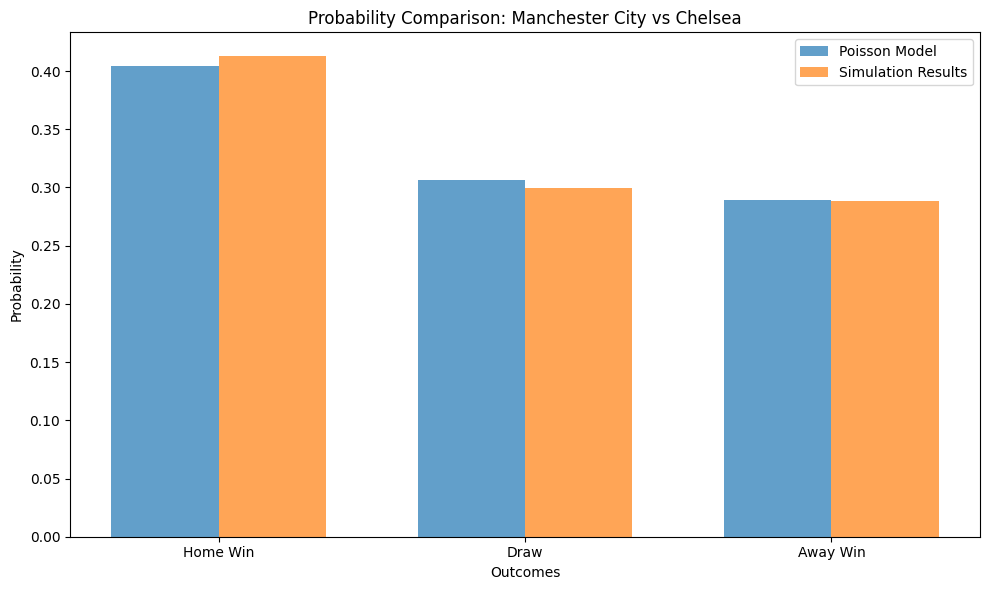


🏟️ Match: Manchester City vs Chelsea
        Outcome  Simulated Count Simulated %                 Metric   Value
0  Home Victory             4126       41.3%  Most Common Scoreline  (1, 0)
1  Away Victory             2880       28.8%         Avg Home Goals    1.19
2          Draw             2994       29.9%         Avg Away Goals    0.92

  Interpretation:
  Chi-square shows Poisson and Simulation probabilities are consistent
  KL-Divergence shows the distributions are very similar (low divergence).


In [33]:
test_single_game_simulation("Manchester City", "Chelsea", 10000)    

----
##### Case 2: Manchester City vs Ipswich Town
Comparing to case 1, examing a stronger team to a weaker team.
Expectation: Man City should be considerably better than Ipswich Town

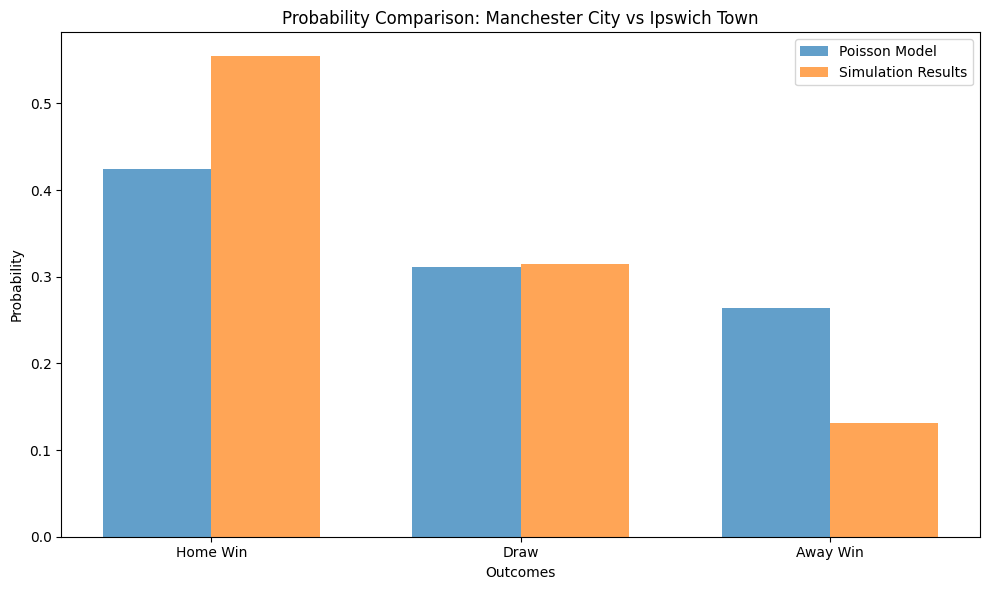


🏟️ Match: Manchester City vs Ipswich Town
        Outcome  Simulated Count Simulated %                 Metric   Value
0  Home Victory             5543       55.4%  Most Common Scoreline  (1, 0)
1  Away Victory             1314       13.1%         Avg Home Goals    1.22
2          Draw             3143       31.4%         Avg Away Goals    0.45

  Interpretation:
  Chi-sqaure shows potential differences in probability distributions
  KL-Divergence shows the distributions have some differences, but are still reasonably close.


In [34]:
test_single_game_simulation("Manchester City", "Ipswich Town", 10000)

----
##### Case 3: Chelsea vs Manchester City
Comparing to case 1, examing the effect of being home and away team
Expectation: Man City should still be better than Chelsea, but the gap should shrink as now Chelsea is the home team

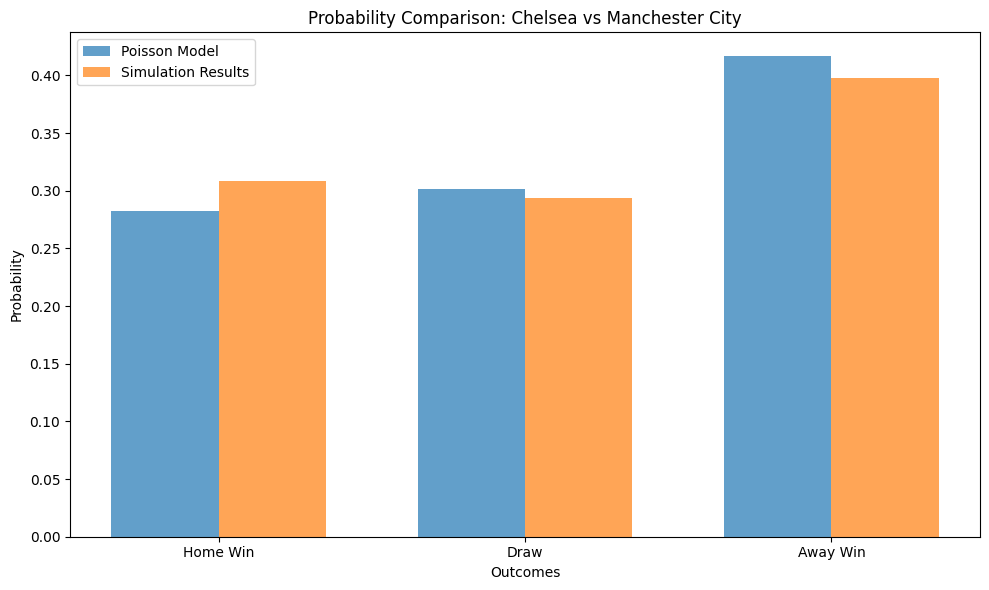


🏟️ Match: Chelsea vs Manchester City
        Outcome  Simulated Count Simulated %                 Metric   Value
0  Home Victory             3086       30.9%  Most Common Scoreline  (0, 1)
1  Away Victory             3974       39.7%         Avg Home Goals    0.99
2          Draw             2940       29.4%         Avg Away Goals    1.18

  Interpretation:
  Chi-sqaure shows potential differences in probability distributions
  KL-Divergence shows the distributions are very similar (low divergence).


In [35]:
test_single_game_simulation("Chelsea", "Manchester City", 10000)

----
##### Conclusion on the Model's Behavior

The performance of the model, as observed in the diagrams, demonstrates the following key points:

1. __General Performance__: The model generally performs well, producing simulated match scorelines that closely align with real-world outcomes. The distribution of home wins, away wins, and draws reflects realistic patterns observed in actual matches.

2. __Behavior Against Different Team Strengths__: The model performs more accurately when the competing teams have players of comparable skill levels. However, in matches between a stronger and a weaker team, the model tends to exaggerate the stronger team's advantage, potentially overestimating the disparity in outcomes.

##### Opportunities for Improvement

__Linear Regression__

Currently, we rely on Poisson simulation data to guide adjustments in parameter values, particularly in the logic governing shooting attempts. For example, when the simulated draw probability is significantly lower than the Poisson-predicted draw probability, we reduce the base shooting probability to increase the likelihood of draws.

However, the Poisson simulation data has its limitations, particularly in how team lambda is calculated. Currently, we simply sum the individual lambda values of each player in the lineup, which may not accurately reflect the true dynamics of a team’s performance.

Introducing linear regression could significantly enhance the model’s accuracy and adaptability. 

By refining critical components such as shooting attempts, passing probabilities, and team lambda aggregation, linear regression can provide more precise estimates and better account for the complex interplay of factors influencing match outcomes. This integration would allow for a more nuanced and data-driven approach to optimizing parameter values.

*** Additionally, by introducing chi-squared test, we learned that it could be too sensitive against a very large sample size. Instead KL divergence measures how one probability distribution diverges from another. It provides a more nuanced metric for comparing the distributions than the chi-square test.

----
### Final standing prediction

After validating the model's accuracy by above test cases. We've come to the final standing simulation where we simulate a full football league season, generating a league table based on match results calculated through probabilistic modeling.

The function runs 10000 simulations for each match between two teams to calculate key statistics, including average goals scored by both home and away teams and probabilities for home wins, away wins, and draws. 

These probabilities are normalized and used to randomly determine the outcome of each match, reflecting the inherent variability of real-world sports competitions. The match results update team statistics such as points, goals scored and conceded, matches played, and win/draw/loss counts.

At the end of the season, the league table is constructed by ranking teams based on total points, with additional metrics like goal differences naturally influencing rankings.

This method leverages the power of Monte Carlo simulations to model uncertainty in sports effectively. Future improvements could include integrating external factors such as injuries, weather, or home-field advantages, as well as dynamically adjusting team parameters using Bayesian methods.

In [36]:
def test_one_season():
    """
    Generate the simulation for one season, return the score board
    
    Parameters: no parameter
    
    Returns: a dictionary with team name as key, their score and goals as value
    """
    
    # Initialize season standings
    league_table = {team: {
        "points": 0,
        "goals_scored": 0,
        "goals_conceded": 0,
        "matches_played": 0,
        "wins": 0,
        "draws": 0,
        "losses": 0
    } for team in teams}
    
    num_simulations = 1000
    
    # Simulate matches for the entire season
    for home_team in teams:
        for away_team in teams:
            # Don't play against itself
            if home_team != away_team:
                # Simulate the match
                match_results = monte_carlo_match_simulation_parallel(home_team, away_team, num_simulations)
                
                # Update team statistics
                home_stats = league_table[home_team]
                away_stats = league_table[away_team]
                
                # Update matches played
                home_stats["matches_played"] += 1
                away_stats["matches_played"] += 1
                
                # Update goals
                home_stats["goals_scored"] += match_results["average_home_goals"]
                home_stats["goals_conceded"] += match_results["average_away_goals"]
                away_stats["goals_scored"] += match_results["average_away_goals"]
                away_stats["goals_conceded"] += match_results["average_home_goals"]
                
                # Update points and match results
                home_vic = match_results["home_vic"]
                away_vic = match_results["away_vic"]
                draw = num_simulations - home_vic - away_vic

                # normalised values
                nld_hv = home_vic / num_simulations
                nld_av = away_vic / num_simulations
                nld_draw = draw / num_simulations
                
                game_result = random.choices(
                    population=["home_vic", "away_vic", "draw"],
                    weights=[nld_hv, nld_av, nld_draw],
                    k=1
                )[0]
                
                if game_result == "home_vic":
                    home_stats["points"] += 3
                    home_stats["wins"] += 1
                    away_stats["losses"] += 1 
                elif game_result == "away_vic":
                    away_stats["points"] += 3
                    away_stats["wins"] += 1
                    home_stats["losses"] += 1
                else:
                    home_stats["points"] += 1
                    away_stats["points"] += 1
                    home_stats["draws"] += 1
                    away_stats["draws"] += 1 
                '''
                if draw > home_vic and draw > away_vic:
                    home_stats["points"] += 1
                    away_stats["points"] += 1
                    home_stats["draws"] += 1
                    away_stats["draws"] += 1 
                elif home_vic > away_vic: 
                    home_stats["points"] += 3
                    home_stats["wins"] += 1
                    away_stats["losses"] += 1
                else: # home_vic < away_vic
                    away_stats["points"] += 3
                    away_stats["wins"] += 1
                    home_stats["losses"] += 1
                '''
    # Sort teams by points (and potentially goal difference in future iterations)
    sorted_teams = sorted(
        league_table.items(), 
        key=lambda x: x[1]["points"], 
        reverse=True
    )
    
    df = pd.DataFrame.from_dict(league_table, orient='index')

    # Reset index and rename
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'team'}, inplace=True)

    # Convert data types if necessary
    df['goals_scored'] = df['goals_scored'].astype(int)
    df['goals_conceded'] = df['goals_conceded'].astype(int)

    # Reorder columns
    df = df[['team', 'matches_played', 'wins', 'draws', 'losses', 'goals_scored', 'goals_conceded', 'points']]

    # Sort by points
    df.sort_values(by='points', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [37]:
def visualize_league_season(league_table):
    """
    Create comprehensive visualizations of the league season results.
    
    Parameters:
    league_table (dict): Dictionary containing team statistics from the season simulation
    
    Creates multiple plots to represent league performance:
    1. Points Distribution Bar Chart
    2. Goals Scored vs Goals Conceded Scatter Plot
    3. Team Performance Radar Chart for Top Teams
    """
    
    # Extract data for plotting
    teams = league_table['team']
    points = league_table['points']
    goals_scored = league_table['goals_scored']
    goals_conceded = league_table['goals_conceded']
    wins = league_table['wins']
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 10))
    plt.suptitle('League Season Performance Analysis', fontsize=16)
    
    # 1. Points Distribution Bar Chart
    plt.subplot(2, 2, 1)
    plt.bar(teams, points, color='skyblue')
    plt.title('Points Distribution')
    plt.xlabel('Teams')
    plt.ylabel('Total Points')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Goals Scored vs Goals Conceded Scatter Plot
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(goals_scored, goals_conceded, c=points, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label='Points')
    plt.title('Goals Scored vs Goals Conceded')
    plt.xlabel('Goals Scored')
    plt.ylabel('Goals Conceded')
    
    # Annotate each point with team names
    for i, team in enumerate(teams):
        plt.annotate(team, (goals_scored[i], goals_conceded[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Team Performance Radar Chart for Top Teams
    # Select top 5 teams based on points
    top_teams = league_table['team'][:5].tolist()
    performance_metrics = league_table[['points', 'goals_scored', 'goals_conceded', 'wins']][:5]
    
    # Normalize the data for radar chart
    metrics = ['points', 'goals_scored', 'goals_conceded', 'wins']
    performance_metrics_normalized = performance_metrics.copy()
    for metric in metrics:
        min_value = performance_metrics[metric].min()
        max_value = performance_metrics[metric].max()
        performance_metrics_normalized[metric] = (performance_metrics[metric] - min_value) / (max_value - min_value)
    
    # Number of variables we're plotting.
    categories = ['Points', 'Goals Scored', 'Goals Conceded', 'Wins']
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    # Initialize the spider plot
    ax = plt.subplot(2, 2, (3, 4), polar=True)
    plt.title('Top 5 Teams Performance Radar Chart', y=1.08)
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories)
    
    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([0.0, 0.5, 1.0], ["0", "0.5", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    
    # Plot each individual team
    for i, team in enumerate(top_teams):
        values = performance_metrics_normalized.loc[performance_metrics_normalized.index[i]].tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=team)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Adjust layout and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [38]:
league_results = test_one_season()

In [39]:
display_columns = league_results.columns.str.replace('_', ' ').str.title()
league_results.rename(dict(zip(league_results.columns, display_columns)), axis='columns')

,Team,Matches Played,Wins,Draws,Losses,Goals Scored,Goals Conceded,Points
0,Manchester City,38,17,15,6,46,28,66
1,Tottenham,38,19,8,11,39,28,65
2,Manchester Utd,38,16,14,8,31,26,62
3,Everton,38,15,13,10,22,26,58
4,Arsenal,38,14,13,11,29,27,55
5,Liverpool,38,13,16,9,40,29,55
6,Newcastle Utd,38,13,14,11,21,25,53
7,Fulham,38,13,14,11,27,28,53
8,Nottingham Forest,38,11,17,10,26,26,50
9,Wolves,38,12,14,12,21,26,50


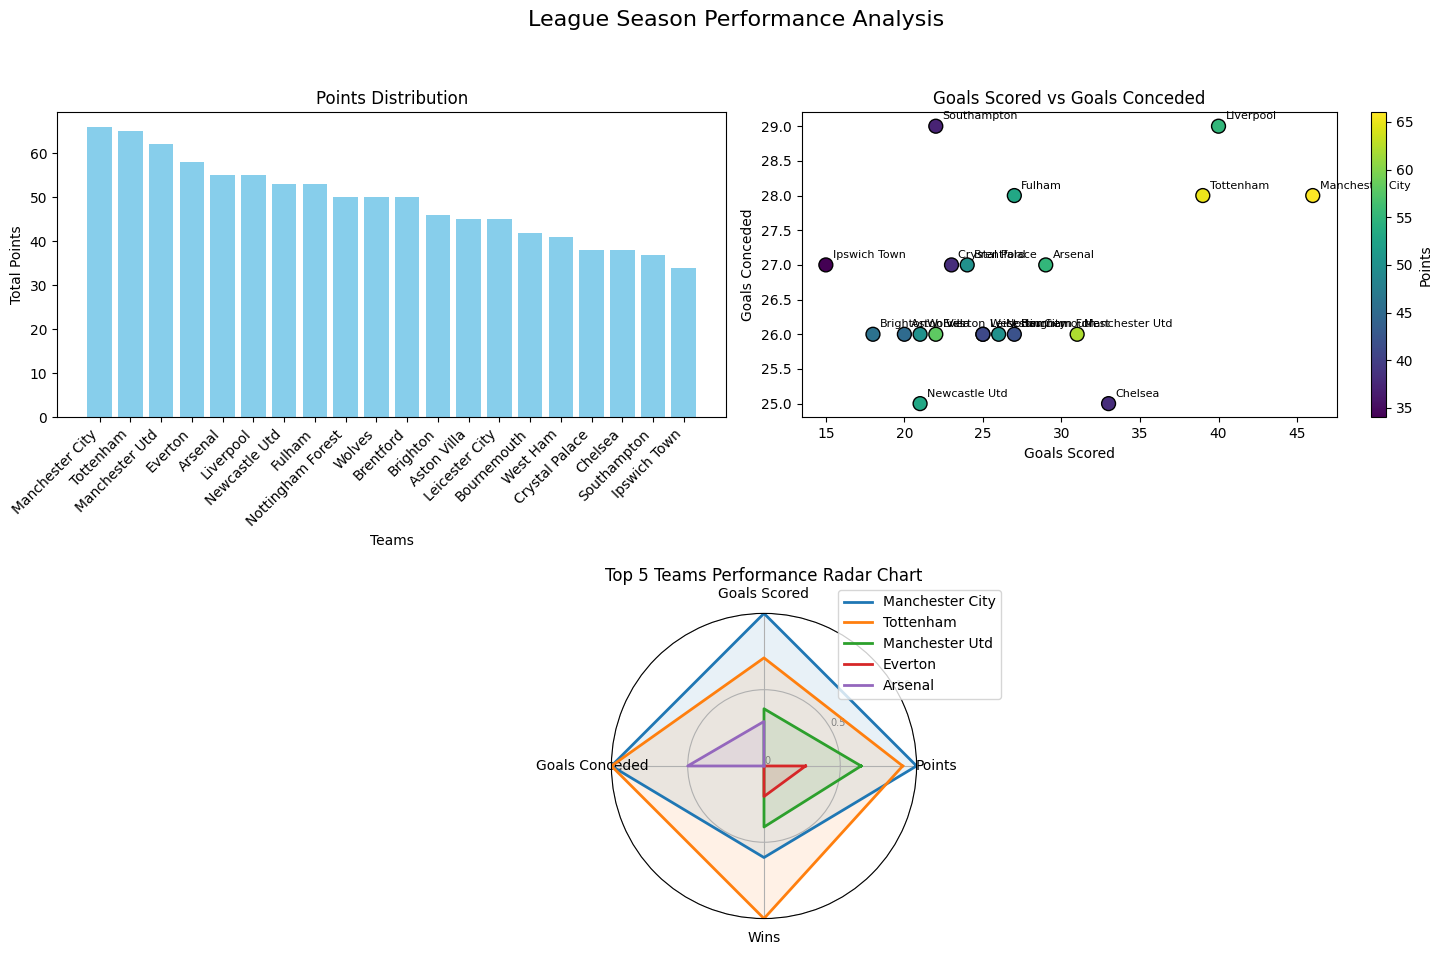

In [40]:
visualize_league_season(league_results)

##### Explanation of Data Selection and Methodology: (DATASCRAPER.py)
This script is designed to scrape, process, and store soccer player data from FBRef to provide detailed statistics for analysis and simulation. Below is a breakdown of why specific data points, methods, and structures were chosen.

What data did we scrape?
- For Goalkeepers: Save Percentage
- Outfield Players: Tackles Per Game, Interceptions Per Game, Shots Per Game, Passes Per Game, Progressive Passes, Progressive Carries Per Game.
- Metrics are normalized on a per-game basis using the gamesPlayed and startsForTeam.
